In [2]:
import numpy as np
np.set_printoptions(threshold=10000,suppress=True)
import pandas as pd
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import torch

## Traitement des données de base

In [36]:
def traitementCSVTemperature(fichier):
    data = pd.read_csv(fichier,sep=';', header=0)
    data = data[['numer_sta','date','t']]
    data['date'] = pd.to_datetime(data['date'], format='%Y%m%d%H%M%S', utc=True)
    data['heure'] = data['date'].dt.hour
    data['date'] = data['date'].dt.date
    #On enlève les stations qui n'ont pas un ID entre 7000 et 8000 (outre-mer)
    data = data[data['numer_sta'] >= 7000]
    data = data[data['numer_sta'] <= 8000]
    data = data[data['t'] != 'mq']
    data['t'] = data['t'].astype(float)
    data['t'] = data['t'] - 273.15
    data = data.groupby(['date','heure','numer_sta']).mean()
    data = data.groupby(['date','heure']).mean()
    data.reset_index(inplace=True)
    return data

In [37]:
def traitementCSVConsomation(fichier):
    rte = pd.read_csv(fichier,sep=';', header=0)
    rte['Date'] = pd.to_datetime(rte['Date'], dayfirst=True)
    rte['Date'] = rte['Date'].dt.date
    rte = rte[rte['Heures'].str.endswith('00')]
    rte['Heures'] = rte['Heures'].str.slice(0,2)
    rte['Heures'] = rte['Heures'].astype(int)
    return rte

In [38]:
def fusionData(rte,temperature):
    data = pd.merge(rte,temperature,how='inner',left_on=['Date','Heures'],right_on=['date','heure'])
    data = data.drop(['date','heure'],axis=1)
    data = data.dropna()
    return data

In [39]:
def traitementAllCSVTemperatures(fichiers):
    data = pd.DataFrame()
    for fichier in fichiers:
        temp = traitementCSVTemperature(fichier)
        data = pd.concat([data,temp])
    data = data.groupby(['date','heure']).mean()
    data.reset_index(inplace=True)
    return data

In [40]:
fichiers_temperature = []
for annee in [2015, 2016, 2017, 2018, 2019]:
    for mois in range(1,13):
        if mois < 10:
            fichiers_temperature.append('temperatures/synop.'+str(annee)+'0'+str(mois)+'.csv')
        else:
            fichiers_temperature.append('temperatures/synop.'+str(annee)+str(mois)+'.csv')
temperatures = traitementAllCSVTemperatures(fichiers_temperature)

In [41]:
rte  = pd.DataFrame()
for annee in [2015, 2016, 2017, 2018, 2019]:
    rte = pd.concat([rte, traitementCSVConsomation('rte_'+str(annee)+'.csv')])

In [42]:
data_total = fusionData(rte,temperatures)

In [43]:
data_total.to_csv('data_total.csv',index=False, sep=';')

## Traitement des données pour apprentissage

In [44]:
def ajouterJourSemaine(data):
    data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
    data['jour_semaine'] = data['Date'].dt.dayofweek
    data['jour_mois'] = data['Date'].dt.day
    data['mois'] = data['Date'].dt.month
    return data

def enleverDate(data):
    data = data.drop(['Date'],axis=1)
    return data


def swap_consommation(df):
    col_list = list(df.columns)
    x, y = col_list.index('Consommation'), col_list.index(df.columns[len(df.columns)-1])
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df


#On met la colonne 'Consommation' en dernière position

data_apprentissage = ajouterJourSemaine(data_total)
data_apprentissage = enleverDate(data_apprentissage)
data_apprentissage = swap_consommation(data_apprentissage)

data_apprentissage.to_csv('data_apprentissage_2018.csv',index=False, sep=';')
data_apprentissage.head(3)

,Heures,mois,t,jour_semaine,jour_mois,Consommation
0,0,1,-0.483333,3,1,74494.0
1,3,1,-1.133333,3,1,68840.0
2,6,1,-1.378571,3,1,64210.0


In [45]:
from sklearn.model_selection import train_test_split
x = data_apprentissage.iloc[:, :-1].values
y = data_apprentissage.iloc[:, -1].values
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

In [91]:

from sklearn.utils import shuffle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DataLoader(object):
    def __init__(self, x, y, batch_size=128, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_idx = 0
        self.data_size = x.shape[0]
        if self.shuffle:
            self.reset()

    def reset(self):
        self.x, self.y = shuffle(self.x, self.y, random_state=1)

    def __iter__(self):
        return self

    def __next__(self):
        if self.start_idx >= self.data_size:
            if self.shuffle:
                self.reset()
            self.start_idx = 0
            raise StopIteration

        batch_x = self.x[self.start_idx:self.start_idx+self.batch_size]
        batch_y = self.y[self.start_idx:self.start_idx+self.batch_size]

        batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
        batch_y = torch.tensor(batch_y, dtype=torch.float, device=device)

        self.start_idx += self.batch_size

        return batch_x, batch_y

class MLP(torch.nn.Module):
    def __init__(self, in_dim, caches, out_dim=1):
        super(MLP, self).__init__()

        assert out_dim==1, 'out_dim must be 1'
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.couches = torch.nn.ModuleList()
        for i in range(len(caches)):
            self.couches.append(torch.nn.Linear(self.in_dim if i == 0 else caches[i-1], caches[i]))
        self.couches.append(torch.nn.Linear(caches[-1], self.out_dim))

    def forward(self, x):
        for i in range(len(self.couches)):
            x = torch.relu(self.couches[i](x))
        x=torch.squeeze(x)
        return x

def mae_loss(y_pred, y_true):
    mae = torch.abs(y_true - y_pred).mean()
    return mae

In [47]:
train_dataloader = DataLoader(x_train, y_train, batch_size=4000)
valid_dataloader = DataLoader(x_test, y_test, batch_size=4000)

In [58]:
def fit(epochs=200, learning_rate=0.1, couche=None, show_loss=True):
    mlp = MLP(x_train[0].shape[0], couche, 1)
    mlp.to(device)
    optimizer = torch.optim.Adam(mlp.parameters(), lr=learning_rate)
    best_loss = np.inf
    valid_losses = []
    for epoch in range(epochs):
        mlp.train()
        for batch_id, (batch_x, batch_y) in enumerate(train_dataloader):
            y_pred = mlp(batch_x)
            loss = mae_loss(y_pred, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        mlp.eval()
        valid_loss = 0
        num_batch = valid_dataloader.data_size // valid_dataloader.batch_size + 1

        for batch_id, (batch_x, batch_y) in enumerate(valid_dataloader):

            y_pred = mlp(batch_x)
            loss = mae_loss(y_pred, batch_y)
            valid_loss += loss.item()

        valid_loss /= num_batch
        valid_losses.append(valid_loss)

        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(mlp.state_dict(), 'mlp.model')
    if show_loss:
        print("Best Loss is " + str(best_loss))
        plt.plot(valid_losses)
        plt.show()
    return mlp, best_loss

In [59]:
nbTest = 10
def testParameters(couches, lr):
    best = np.inf
    best_parameters = None
    for couche in couches:
        print(couche)
        for learning_rate in lr:
            tot_loss = 0
            for numero_test in range(nbTest):
                mlp, best_loss = fit(couche=couche, learning_rate=learning_rate, show_loss=False)
                tot_loss += best_loss
            tot_loss /= nbTest
            if tot_loss < best:
                best = tot_loss
                best_parameters = [couche, learning_rate]
    return best_parameters, best


In [60]:
best_parameters, best = testParameters([[70, 70],[100, 100],[70, 70, 70],[100,100,100]], [1.0, 0.1, 0.01])

[70, 70]
[100, 100]
[70, 70, 70]
[100, 100, 100]


In [71]:
best_parameters

[[100, 100, 100], 0.1]

In [99]:
def predict(model, heure, temperature, jour_semaine, jour_mois, mois):
    toPredict = np.array([[heure, mois, temperature, jour_semaine, jour_mois]])
    toPredict = torch.tensor(toPredict,dtype=torch.float,device=device)
    y_pred = model(toPredict)
    y_pred = y_pred.data.cpu().numpy()
    return y_pred

Best Loss is 3576.703125


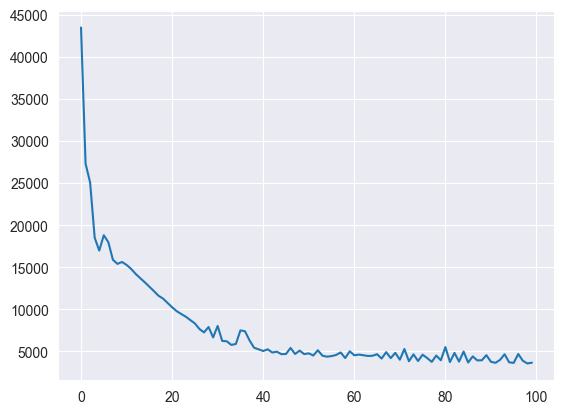

In [106]:
best_model, score = fit(100, 0.1, [70, 70, 70], True)

46635.57
36630.19
38381.004
45938.71
53308.504
52289.605
48285.824
44870.082


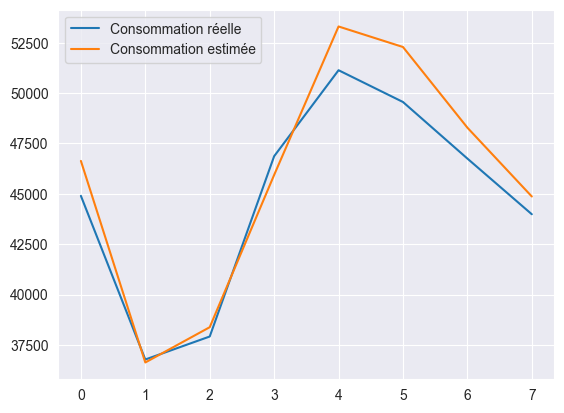

In [117]:
from datetime import datetime


def testDate(date_str: str, model: MLP):
    date=datetime.strptime(date_str, '%d/%m/%y')
    jour_semaine=date.weekday()
    jour_mois=date.day
    mois=date.month
    data_test = ajouterJourSemaine(data_total)
    data_test = swap_consommation(data_test)
    data_test=data_test[data_test['Date']==date_str]
    data_test = enleverDate(data_test)
    data_predict = []
    data_test.reset_index(inplace=True)
    for i,ligne in data_test.iterrows():
        data_predict.append(predict(model, ligne['Heures'], ligne['t'], jour_semaine, jour_mois, mois))
    plt.plot(data_test['Consommation'])
    plt.plot(data_predict)
    plt.legend(['Consommation réelle', 'Consommation estimée'])
    plt.show()

testDate('30/07/19', best_model)